## 신용카드 사기검출

2021-01-18

data출처 : https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


 ## 1. 데이터 로드
 
 * dataset을 DataFrame으로 변환한다
 * Class는 사기여부( 1: 사기케이스)

In [2]:
card_df = pd.read_csv("./creditcard.csv")
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
card_df.info()
card_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

(284807, 31)

총 31개의 column으로 이루어져 있고 데이터 타입은 전부 숫자형이다.

entry는 전부 284807개로 missing value는 없음을 알 수 있다.

## 2. 데이터 전처리

원본 DataFrame과는 별도로 가공을 위한 DataFrame울 복사해 가공한다.

In [4]:
#Time피처는 큰 의미가 없는 피처여서 drop
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

* train_test_split의 기능을 하는 함수를 별도로 만든다.

* 이렇게 하는 이유는 log변환, SMOTE등을 적용하는 과정에서 원본 dataframe을 손상시키지 않기 위해 복사본이 필요하기 때문

In [5]:
from sklearn.model_selection import train_test_split

def get_train_test_dataset(df = None):
    ch_df = get_preprocessed_df(df)
    X_features = ch_df.iloc[:,:-1]
    y_target =ch_df.iloc[:,-1]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target, test_size = 0.3, random_state = 10, stratify=y_target)
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

* 분할이 골고루 됐는지 비율을 구해서 확인 (label 값만 확인하면 됨)

In [6]:
print("train dataset 분할 비율: ")
print(y_train.value_counts()/y_train.shape[0])

print("train dataset 분할 비율: ")
print(y_test.value_counts()/y_test.shape[0])

train dataset 분할 비율: 
0    0.998275
1    0.001725
Name: Class, dtype: float64
train dataset 분할 비율: 
0    0.998268
1    0.001732
Name: Class, dtype: float64


In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 3. 학습

In [8]:
#학습의 과정을 함수화해서 여러가지 학습 방법을 사용할떄 유리하도록 한다.

def model_fit_predict(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    #학습 수행
    model.fit(ftr_train, tgt_train)
    #예측
    pred = model.predict(ftr_test)
    #1일 확률, 사기일 경우만 슬라이싱해서 predict proba로 구함
    pred_proba = model.predict_proba(ftr_test)[:,1]
    
    get_clf_eval(tgt_test, pred, pred_proba) 

* LogisticRegression으로 학습

In [9]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
model_fit_predict(lr_clf, ftr_train = X_train, ftr_test= X_test, tgt_train= y_train, tgt_test=y_test)

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators= 1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
model_fit_predict(lgbm_clf, ftr_train = X_train, ftr_test= X_test, tgt_train= y_train, tgt_test=y_test)


오차 행렬
[[85282    13]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8750, 재현율: 0.6149,    F1: 0.7222, AUC:0.9443
오차 행렬
[[85289     6]
 [   28   120]]
정확도: 0.9996, 정밀도: 0.9524, 재현율: 0.8108,    F1: 0.8759, AUC:0.9772


## 4. 중요 피처 분포도 확인

* 'Amount' 피처 : 카드결제 금액

<AxesSubplot:xlabel='Amount', ylabel='Density'>

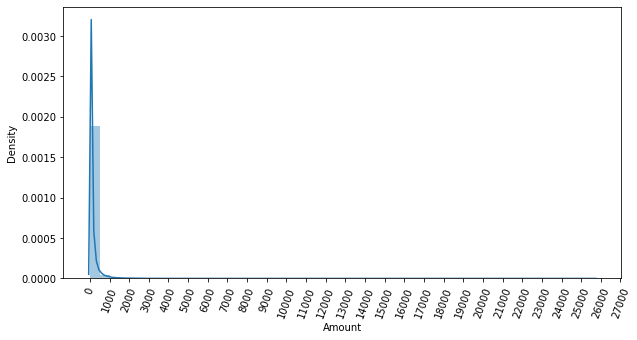

In [10]:
import seaborn as sns

plt.figure(figsize=(10,5))
plt.xticks(range(0,30000,1000), rotation=70)
sns.distplot(card_df['Amount'])

결제 금액이 대부분 500 미만이고 불균형한 분포를 가짐을 확인할 수 있다.

정확한 비교를 위해 Standard Scaler을 이용해 정규분포로 바꿔준다


In [11]:
from sklearn.preprocessing import StandardScaler

#위에서 작성한 get_preprocessed_df함수 새로 작성
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

## 5. 'Amount'피처 스케일링 후 학습/예측


In [12]:
X_train, X_test, y_train,y_test = get_train_test_dataset(card_df)

print("로지스틱 회귀 성능 :")
lr_clf = LogisticRegression()
model_fit_predict(lr_clf, ftr_train = X_train, ftr_test= X_test, tgt_train= y_train, tgt_test=y_test)
print("lightGBM 회귀 성능 :")
lgbm_clf = LGBMClassifier(n_estimators= 1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
model_fit_predict(lgbm_clf, ftr_train = X_train, ftr_test= X_test, tgt_train= y_train, tgt_test=y_test)



로지스틱 회귀 성능 :
오차 행렬
[[85285    10]
 [   63    85]]
정확도: 0.9991, 정밀도: 0.8947, 재현율: 0.5743,    F1: 0.6996, AUC:0.9840
lightGBM 회귀 성능 :
오차 행렬
[[85289     6]
 [   27   121]]
정확도: 0.9996, 정밀도: 0.9528, 재현율: 0.8176,    F1: 0.8800, AUC:0.9830


* Amount를 로그변환


In [13]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    #
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [14]:
X_train, X_test, y_train,y_test = get_train_test_dataset(card_df)

print("로지스틱 회귀 성능 :")
lr_clf = LogisticRegression()
model_fit_predict(lr_clf, ftr_train = X_train, ftr_test= X_test, tgt_train= y_train, tgt_test=y_test)
print("lightGBM 회귀 성능 :")
lgbm_clf = LGBMClassifier(n_estimators= 1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
model_fit_predict(lgbm_clf, ftr_train = X_train, ftr_test= X_test, tgt_train= y_train, tgt_test=y_test)



로지스틱 회귀 성능 :
오차 행렬
[[85285    10]
 [   62    86]]
정확도: 0.9992, 정밀도: 0.8958, 재현율: 0.5811,    F1: 0.7049, AUC:0.9807
lightGBM 회귀 성능 :
오차 행렬
[[85289     6]
 [   28   120]]
정확도: 0.9996, 정밀도: 0.9524, 재현율: 0.8108,    F1: 0.8759, AUC:0.9761


## 6. 이상치 제거후 학습/예측

결정 레이블값과 가장 상관도가 높은 피처 추출

<AxesSubplot:>

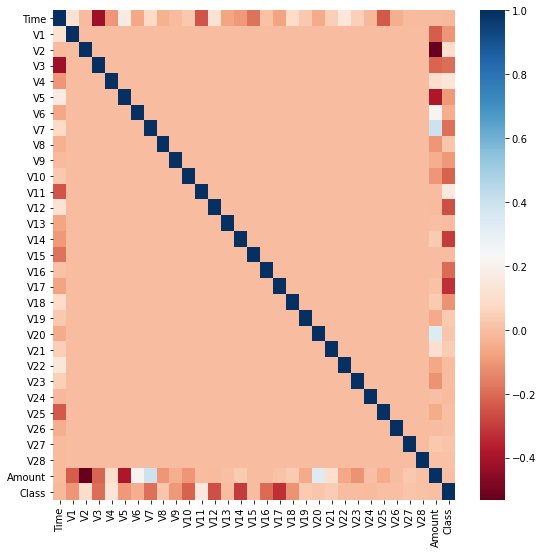

In [15]:
import seaborn as sns

plt.figure(figsize=(9, 9))
#각각의 칼럼들끼리의 상관도 인자로 전달
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu') #cmap = 칼라맵

'Class'값과 가장 관련이 있는 피처 : V14

In [16]:
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [17]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


* Amount 값 로그 변환 후 V14 피터의 Outlier제거하는 함수 get_preprocessed_df 새로 작성

In [18]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측:')
model_fit_predict(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('LightGBM 예측:')
model_fit_predict(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


로지스틱 회귀 예측:
오차 행렬
[[85284    11]
 [   57    89]]
정확도: 0.9992, 정밀도: 0.8900, 재현율: 0.6096,    F1: 0.7236, AUC:0.9748
LightGBM 예측:
오차 행렬
[[85293     2]
 [   31   115]]
정확도: 0.9996, 정밀도: 0.9829, 재현율: 0.7877,    F1: 0.8745, AUC:0.9815


* 이상치 제거후 로지스틱 회귀의 경우 재현율이 상당히 증가함을 알 수 있다.

= FN 값이 줄어들었다고 볼 수 있는데 신용카드 사기와 같이 사기가 아니라고 예측했다 틀리는 경우가 적어야 되는 케이스에서는 재현율이 성능을 보여주는 중요한 지표가 될 수 있다.

## 7. SMOTE 오버 샘플링 적용 후 학습/예측

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over , y_train_over = smote.fit_sample(X_train, y_train)

In [20]:
print("SMOTE 전", X_train.shape, y_train.shape)
print("SMOTE 후", X_train_over.shape, y_train_over.shape)
print("SMOTE 후 레이블 값 분포\n",pd.Series(y_train_over).value_counts())

SMOTE 전 (199362, 29) (199362,)
SMOTE 후 (398040, 29) (398040,)
SMOTE 후 레이블 값 분포
 1    199020
0    199020
Name: Class, dtype: int64


* 적용후 데이터 값이 거의 두배 증식됐음을 확인할 수 있다.

In [21]:
print('오버 샘플링 후 로지스틱 회귀 예측:')
model_fit_predict(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

print('오버 샘플링 후 LightGBM 예측:')
model_fit_predict(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)
 

오버 샘플링 후 로지스틱 회귀 예측:
오차 행렬
[[82994  2301]
 [   12   134]]
정확도: 0.9729, 정밀도: 0.0550, 재현율: 0.9178,    F1: 0.1038, AUC:0.9711
오버 샘플링 후 LightGBM 예측:
오차 행렬
[[85271    24]
 [   29   117]]
정확도: 0.9994, 정밀도: 0.8298, 재현율: 0.8014,    F1: 0.8153, AUC:0.9562


* smote후 로지스틱 회귀의 경우, 제현울은 좋지만 정밀도가 너무 낮아 부적합한 모델이 됨

## 8. Precision Recall 곡선 시각화

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    


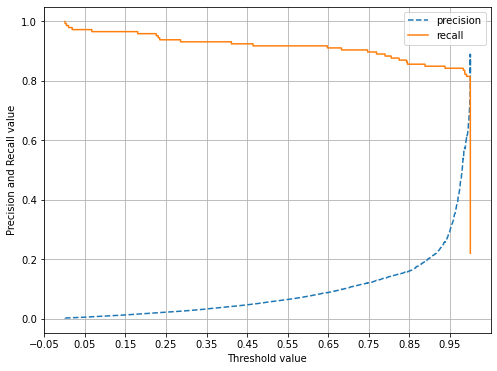

In [23]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )